In [1]:
# Parameters
EXP_NUM = "default"

In [2]:
# Parameters
EXP_NUM = "exp043"


# 2023 1st place solution
[kaggle notebook](https://www.kaggle.com/code/rustyb/paris-madness-2023#Load-the-data!)

# コードの流れ
1. hydraからハイパラ取得し、パスなどを設定

    regular&tourney Detaile Result, Seedを使用し、tourneyを目的変数としてモデルを予測していく

    regular_data->season_statistics->

    以下の前処理をする

2. データ２倍にかさまし
3. regularに対して特徴量の追加
    各チームごとに加えるもの
   - EFFG: フィールドゴール成功率
   - EFFG3: フィールドゴール3p成功率
   - DARE: フィールドゴールにおける3P率
   - "win"を目的変数とする(Team, Season)のロジスティック回帰した各係数
    対戦カードごとに加える特徴量
    - PointDiff: ポイント差
    - win: 1 if PointDiff>0 else 0
4. (Team, Season)ごとに特徴量season_statixtics追加
    - win_ratio_14d
    - box score mean
    - quality
    - seed
5. season_average.enabled=trueなら直近３シーズンの加重平均の処理加える
6. tourneyをteamID, Season, score(y)のみ取り出してこれに対してseason_statisticsの結合と特徴量微調整
   - seed->seeddiff
   - fillna()

7. モデル構築
8. KFOLD->OOF予測->spline曲線求めてlogloss算出
    - KFOLDによる交差検証（CV）
        repeat_cv 回のループで、各反復ごとにKFold（folds_splits個）によりデータを分割し、XGBoostのCVを実行しています。
        各foldでの結果（例えば、訓練MAE、検証MAEの平均値や標準偏差）がcv_resultとして得られ、それをxgb_cvリストに格納します。
        この段階で重要なのは、各反復での検証用MAEの平均値 (test-mae-mean) の最小値と、そのときのブーストラウンド数です。
        それらは後で、最適なイテレーション数 (iteration_counts) として計算され、val_mae にも格納されます。
    - OOF予測の流れ

        各反復ごとに、新たなKFoldを用いてデータを分割。
        各foldごとに、学習データでモデルを訓練し、検証データに対して予測を実施。
        すべてのfold分の予測結果を1つの予測配列にまとめ、最後に -30～30 の範囲にクリップしています。
        重要な結果

        OOF予測結果（oof_preds）自体は後段で別途評価指標に使用できるほか、各反復ごとの予測精度や誤差を算出する際の基礎データ
9.  提出フェーズ
    - 最適paramで全データ使って訓練
    - 提出試合の予測

memo

欠損値が発生していいのか検討して保管について考える
seedがかけているのはregularに対してseedを与えているから大丈夫。最終的なtourneyには欠損０で追加できているから問題ない

In [3]:
import os
print("Current working directory:", os.getcwd())
print("これ出力されてんの？")

Current working directory: c:\Users\81809\Documents\ALL_CODE\kaggle\March Machine Learning Mania 2025\notebook
これ出力されてんの？


In [4]:

import os
import sys
from pathlib import Path
import collections
from datetime import datetime
import shutil
import yaml
from tqdm import tqdm
import time
import optuna
from loguru import logger
import collections

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss,mean_squared_error, mean_absolute_error, roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.isotonic import IsotonicRegression

import statsmodels.api as sm

START_TIME = time.time()


#####
#EXP_NUM = "exp030"
#####
print(EXP_NUM)

# hydraの初期設定と指定ハイパラの取得
sys.path.append(os.path.abspath("/workspace"))
sys.path.append("C:\\Users\\81809\\Documents\\ALL_CODE\\kaggle\\March Machine Learning Mania 2025")
with initialize_config_module(version_base=None, config_module="conf"):
    cfg = compose(
        config_name="base.yaml",
        overrides=[
            f"+exp={EXP_NUM}" #defaultexp001->exp002のオーバーライド
        ],
    )
    
    OmegaConf.resolve(cfg)
    print("Omega conf is below")
    print(OmegaConf.to_yaml(cfg))


C:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


exp043
Omega conf is below
dir:
  input_dir: ../input
  output_dir: ../output
  src_path: ../src
  conf_path: ../conf
exp:
  name: allremove_normalfeature
  print_name: remove normal feature
  tournament:
    use_start_season: 1985
    target_season: 2021
  features:
    cal_mean_boxscore:
      T1_Score: true
      T2_Score: true
      PointDiff: true
      T1_FGM: false
      T2_FGM: false
      T1_FGA: false
      T2_FGA: false
      T1_FGM3: false
      T2_FGM3: false
      T1_FGA3: false
      T2_FGA3: false
      T1_FTM: false
      T2_FTM: false
      T1_FTA: false
      T2_FTA: false
      T1_EFFG: false
      T2_EFFG: false
      T1_EFFG3: false
      T2_EFFG3: false
      T1_EFG_SUM: true
      T2_EFG_SUM: true
      T1_TO_RATIO: true
      T2_TO_RATIO: true
      T1_OR: false
      T2_OR: false
      T1_DR: false
      T2_DR: false
      T1_REB_RATE: true
      T2_REB_RATE: true
      T1_FT_RATE: true
      T2_FT_RATE: true
      T1_RATING: false
      T2_RATING: false
     

In [5]:
PREDICT_YEAR = cfg.exp.tournament.target_season
name = f"{cfg.exp.name}"
now = str(datetime.now())
print("########")
print(f"output dir name: {name}")
print(f"Run on {now}")
print(cfg.exp.print_name)
print("########")

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
CONF_PATH = os.path.join(BASE_DIR, "conf")
INPUT_PATH = os.path.join(BASE_DIR, "input")
EXP_PATH = os.path.join(CONF_PATH, "exp", f"{EXP_NUM}.yaml")
OUTPUT_PATH = os.path.join(BASE_DIR, "output", name)
SRC_PATH = cfg.dir.src_path
sys.path.append(SRC_PATH)

os.makedirs(OUTPUT_PATH, exist_ok=True)  
with open(EXP_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
shutil.copyfile(EXP_PATH, os.path.join(OUTPUT_PATH, f"{EXP_NUM}.yaml"))


y_season = cfg.exp.tournament.target_season
FEATURES = cfg.exp.features
MODEL = cfg.exp.model
results = [f"-----{PREDICT_YEAR}-----", now ,name, cfg.exp.print_name,""]

########
output dir name: allremove_normalfeature
Run on 2025-03-12 21:28:02.080863
remove normal feature
########


In [6]:
tourney_results = pd.concat([
    pd.read_csv(os.path.join(INPUT_PATH,"MNCAATourneyDetailedResults.csv")),
    pd.read_csv(os.path.join(INPUT_PATH,"WNCAATourneyDetailedResults.csv")),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(os.path.join(INPUT_PATH,"MNCAATourneySeeds.csv")),
    pd.read_csv(os.path.join(INPUT_PATH,"WNCAATourneySeeds.csv")),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(os.path.join(INPUT_PATH, "MRegularSeasonDetailedResults.csv")),
    pd.read_csv(os.path.join(INPUT_PATH,"WRegularSeasonDetailedResults.csv")),
], ignore_index=True)

ordinal_rank = pd.read_csv(os.path.join(INPUT_PATH, "MMasseyOrdinals.csv"))

# 1試合情報からWin,Lose反転させてデータ数２倍にかさまし and WLoc -> location(0 or -1 or 1)
def prepare_data(df1):
    df = df1.copy()
    ### add new box score
    #type1: normal EFG
    df['WEFFG'] = df['WFGM'] / df['WFGA']
    df['LEFFG'] = df['LFGM'] / df['LFGA']
    #type2: 1stfeature EFG
    df['WEFFG3'] = np.where(df['WFGA3'] == 0, 0, df['WFGM3'] / df['WFGA3'])
    df['LEFFG3'] = np.where(df['LFGA3'] == 0, 0, df['LFGM3'] / df['LFGA3'])
    df['WDARE'] = df['WFGM3'] / df['WFGM']
    df['LDARE'] = df['LFGM3'] / df['LFGM']
    df['WTOQUETOQUE'] = df['WAst'] / df['WFGM']
    df['LTOQUETOQUE'] = df['LAst'] / df['LFGM']
    #type3: OFF/DEF FGE
    df["WEFG_SUM"] = (df["WFGM"]+0.5*df["WFGM3"])/df["WFGA"]
    df["LEFG_SUM"] = (df["LFGM"]+0.5*df["LFGM3"])/df["LFGA"]

    #POSS RATE
    df["WPOSS"] = df["WFGA"] + 0.44*df["WFTA"] - df["WOR"] + df["WTO"]
    df["LPOSS"] = df["LFGA"] + 0.44*df["LFTA"] - df["LOR"] + df["LTO"]
    df["WPOSS_RATE"] = df["WPOSS"]/(df["WPOSS"]+df["LPOSS"])
    df["LPOSS_RATE"] = df["LPOSS"]/(df["WPOSS"]+df["LPOSS"])
    
    #TO Ratio 
    df["WTO_RATIO"] = df["WTO"]/(df["WFGA"]+0.44*df["WFTA"]+df["WTO"])#POSS RATEと違ってOR入っていない
    df["LTO_RATIO"] = df["LTO"]/(df["LFGA"]+0.44*df["LFTA"]+df["LTO"])
    
    # REB%
    df["WREB_RATE"] = df["WOR"]/(df["WOR"]+df["LDR"])
    df["LREB_RATE"] = df["LOR"]/(df["LOR"]+df["WDR"])
    
    #FT %
    df["WFT_RATE"] = df["WFTA"]/df["WFGA"]
    df["LFT_RATE"] = df["LFTA"]/df["LFGA"]
    
    #rating
    df["WRATING"] = df["WScore"]/df["WPOSS"]
    df["LRATING"] = df["LScore"]/df["LPOSS"]
        
    #0除算補完
    print(df.info())
        
    #かさましに伴う反転カラム
    dfswap = df.copy()
    # Home, Away変換して反転
    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
    #反転
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    
    
    #add new feature
    #locationを数値に変換
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    #add PointDiff&win
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output["win"] = np.where(output['PointDiff']>0,1,0)
    
    
    print(f"feature cols after prepare()")
    print(output.columns)
    return output



In [7]:
import numpy as np

# 異常値のチェック
def check_abnormal_values(df):
    print("各カラムの異常値の個数を表示します。\n")

    for col in df.columns:
        nan_count = df[col].isna().sum()  # NaN の数
        inf_count = (df[col] == np.inf).sum()  # inf の数
        neg_inf_count = (df[col] == -np.inf).sum()  # -inf の数

        if nan_count > 0 or inf_count > 0 or neg_inf_count > 0:
            print(f"Column: {col}")
            print(f"  NaN    : {nan_count}")
            print(f"  Inf    : {inf_count}")
            print(f"  -Inf   : {neg_inf_count}")
            print("-" * 30)

# 関数を実行
check_abnormal_values(regular_results)


各カラムの異常値の個数を表示します。



In [8]:
#予測する年以降の情報はフィルタリング
USE_START_YEAR = cfg.exp.tournament.use_start_season
notexist = tourney_results[tourney_results["Season"] == PREDICT_YEAR]
tourney_results = tourney_results[(tourney_results["Season"] >= USE_START_YEAR) & (tourney_results["Season"] < PREDICT_YEAR)]
seeds = seeds[(seeds["Season"] >= USE_START_YEAR) & (seeds["Season"] <= PREDICT_YEAR)]
regular_results = regular_results[(regular_results["Season"] >= USE_START_YEAR) & (regular_results["Season"] <= PREDICT_YEAR)]

regular_data = prepare_data(regular_results)
display(regular_data.head(), regular_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 157103 entries, 0 to 178864
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Season       157103 non-null  int64  
 1   DayNum       157103 non-null  int64  
 2   WTeamID      157103 non-null  int64  
 3   WScore       157103 non-null  int64  
 4   LTeamID      157103 non-null  int64  
 5   LScore       157103 non-null  int64  
 6   WLoc         157103 non-null  object 
 7   NumOT        157103 non-null  int64  
 8   WFGM         157103 non-null  int64  
 9   WFGA         157103 non-null  int64  
 10  WFGM3        157103 non-null  int64  
 11  WFGA3        157103 non-null  int64  
 12  WFTM         157103 non-null  int64  
 13  WFTA         157103 non-null  int64  
 14  WOR          157103 non-null  int64  
 15  WDR          157103 non-null  int64  
 16  WAst         157103 non-null  int64  
 17  WTO          157103 non-null  int64  
 18  WStl         157103 non-null 

feature cols after prepare()
Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'T1_EFFG', 'T2_EFFG', 'T1_EFFG3', 'T2_EFFG3', 'T1_DARE', 'T2_DARE',
       'T1_TOQUETOQUE', 'T2_TOQUETOQUE', 'T1_EFG_SUM', 'T2_EFG_SUM', 'T1_POSS',
       'T2_POSS', 'T1_POSS_RATE', 'T2_POSS_RATE', 'T1_TO_RATIO', 'T2_TO_RATIO',
       'T1_REB_RATE', 'T2_REB_RATE', 'T1_FT_RATE', 'T2_FT_RATE', 'T1_RATING',
       'T2_RATING', 'PointDiff', 'win'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314206 entries, 0 to 314205
Data columns (total 58 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Season 

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T1_TO_RATIO,T2_TO_RATIO,T1_REB_RATE,T2_REB_RATE,T1_FT_RATE,T2_FT_RATE,T1_RATING,T2_RATING,PointDiff,win
0,2003,10,1104,68,1328,62,0,0,27,58,...,0.258659,0.223104,0.388889,0.294118,0.310345,0.415094,0.907635,0.877193,6,1
1,2003,10,1272,70,1393,63,0,0,26,62,...,0.155950,0.136674,0.375000,0.416667,0.306452,0.298507,1.023991,0.929204,7,1
2,2003,11,1266,73,1437,61,0,0,24,58,...,0.123824,0.126156,0.435897,0.543860,0.500000,0.315068,1.144918,0.951341,12,1
3,2003,11,1296,56,1457,50,0,0,18,38,...,0.188561,0.254692,0.230769,0.472222,0.815789,0.306122,0.971548,0.868056,6,1
4,2003,11,1400,77,1208,71,0,0,30,61,...,0.173439,0.119218,0.531250,0.488372,0.213115,0.435484,1.208412,1.129135,6,1


None

In [9]:
#使用特徴量(boxscore_cols)を取得してそれに対して("Season", 'T1_TeamID')でまとめた特徴量の追加
#### 1. win_ration_14d ####
def add_win_ratio_14d(df):
    df_filtered = df[df['DayNum'] > 118].copy()
    df_filtered['Win'] = (df_filtered['PointDiff'] > 0).astype(int)
    
    win_ratio_t1 = df_filtered.groupby(['Season', 'T1_TeamID'])['Win'].mean().reset_index()
    win_ratio_t1.rename(columns={'Win': 'T1_win_ratio_14d'}, inplace=True)
    
    win_ratio_t2 = df_filtered.groupby(['Season', 'T2_TeamID'])['Win'].mean().reset_index()
    win_ratio_t2.rename(columns={'Win': 'T2_win_ratio_14d'}, inplace=True)
    
    df = df.merge(win_ratio_t1, on=['Season', 'T1_TeamID'], how='left')
    df = df.merge(win_ratio_t2, on=['Season', 'T2_TeamID'], how='left')
    
    return df

##### 2. add mean of boxscore ####
def make_col_avg(df, boxscore, group = ["Season", "T1_TeamID"], func= [np.mean]):
    df_stat = df.groupby(group)[boxscore].agg(func)
    df_stat.columns = [''.join(col).strip() for col in df_stat.columns.values]
    df_stat = df_stat.reset_index()

    win_ratio_cols = ['T1_win_ratio_14d'] #ここマージの関係からT2_win_ratio_14dを外したけど大丈夫か考える
    df_win_ratio = df[group + win_ratio_cols].drop_duplicates()
    df_stat = df_stat.merge(df_win_ratio, on=group, how='left')
    
    return df_stat

#### 3. add team quality ####
# 3.0 ロジスティックを行うためのregular_season_effectsデータフレームの作成
def make_regular_season_effects(df):
    regular_season_effects = df[['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff']].copy()
    regular_season_effects['win'] = np.where(regular_season_effects['PointDiff'] > 0, 1, 0)
    return regular_season_effects

# 3.1
#各シーズンごとの総当たりに対するロジスティック回帰を行う
#目的変数はfeatureenginneringから作成したPointDiffの正負に依存するWinとする.
#新たな特徴量"quarity"をseasonごとの戦績をもとにロジスティックの回帰係数として導入している
def team_quality(season,df):
    season_data = df[df["Season"] == season]
    X = season_data[['T1_TeamID', 'T2_TeamID']]
    y = season_data['win']
    print(X.shape, y.shape)
    encoder = OneHotEncoder(sparse_output=False) #多重共線性防止, 密行列指定
    X_encoded = encoder.fit_transform(X)
    
    model = LogisticRegression(fit_intercept=False)
    model.fit(X_encoded, y)
    team_ids = encoder.get_feature_names_out(['T1_TeamID', 'T2_TeamID'])

    
    #quarity: (チーム数)*2(ID, 回帰係数)
    quality = pd.DataFrame({
        'TeamID': team_ids,
        'quality': model.coef_.flatten() #T1_TeamID_1112,,,の形でチーム数分の回帰係数が入る
    })

    # 値をint 1112 のように整形
    quality = quality[quality['TeamID'].str.contains('T1_TeamID')]
    quality['TeamID'] = quality['TeamID'].str.replace('T1_TeamID_', '', regex=True).astype(int)
    quality['Season'] = season

    #display(quality.head())
    print(f"fin make {season}'s team quarity")
    return quality

# 4. add seed
def add_seed(df, seeds):
    temp = seeds.copy()
    temp['Seed'] = temp['Seed'].apply(lambda x: int(x[1:3]))
    temp.columns = ['Season','T1_seed','T1_TeamID']
    df = pd.merge(df, temp, on=["Season", "T1_TeamID"], how="left")
    return df 

# 5. add Ordinal rank
def add_ordinalrank(df, ordinal):
    df_rank = ordinal.groupby(["Season", "TeamID"])["OrdinalRank"].agg(np.mean).reset_index()
    df_rank.head()
    ranks = df_rank.rename(columns={'TeamID': 'T1_TeamID', 'OrdinalRank': 'T1_OrdinalRank'})
    df = pd.merge(df,ranks,on = ["Season","T1_TeamID"],how = "left")
    return df

# main 
def make_season_statistics(df, boxscore, seeds, func = [np.mean]):
    # 1. Win Ratio の計算と追加
    add_win = add_win_ratio_14d(df)
    print("after add win ratio")
    print(add_win.columns)  
    
    #2. 
    add_mean = make_col_avg(add_win, boxscore)
    print("after mean of boxscore")
    print(add_mean.columns)
    
    #3. 
    global PREDICT_YEAR, USE_START_YEAR
    start_season = max(FEATURES.start_quality_season, USE_START_YEAR)
    print(f"use season for quality feature is: {start_season}")
    regular_season_effects = make_regular_season_effects(df)
    glm_season = [i for i in range(start_season, PREDICT_YEAR+1)]
    glm_season.remove(2020)
    glm_quality = pd.concat([team_quality(season, regular_season_effects) for season in glm_season]).reset_index(drop=True)
    # add glm quality 
    glm_quality_T1 = glm_quality.rename(columns={'TeamID': 'T1_TeamID', 'quality': 'T1_quality'})
    add_glm = add_mean.merge(glm_quality_T1, on=['Season', 'T1_TeamID'], how='left')

    print("add glm quality")
    print(add_glm.columns)
    
    #4. 
    add_seeds = add_seed(add_glm, seeds)
    print("add seeds (final form)")
    print(add_seeds.columns)
    
    #5. 
    add_rank = add_ordinalrank(add_seeds, ordinal_rank)
    print("add ordinal rank")
    print(add_rank.columns)  
    return add_rank

In [10]:
features = FEATURES.cal_mean_boxscore
boxscore_cols = [col for col, use in features.items() if use]
print("use boxscore col is")
print(boxscore_cols)

season_statistics = make_season_statistics(regular_data, boxscore_cols, seeds, func = [np.mean])
season_statistics.tail()

use boxscore col is
['T1_Score', 'T2_Score', 'PointDiff', 'T1_EFG_SUM', 'T2_EFG_SUM', 'T1_TO_RATIO', 'T2_TO_RATIO', 'T1_REB_RATE', 'T2_REB_RATE', 'T1_FT_RATE', 'T2_FT_RATE', 'T1_POSS_RATE', 'T2_POSS_RATE']


after add win ratio
Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'T1_EFFG', 'T2_EFFG', 'T1_EFFG3', 'T2_EFFG3', 'T1_DARE', 'T2_DARE',
       'T1_TOQUETOQUE', 'T2_TOQUETOQUE', 'T1_EFG_SUM', 'T2_EFG_SUM', 'T1_POSS',
       'T2_POSS', 'T1_POSS_RATE', 'T2_POSS_RATE', 'T1_TO_RATIO', 'T2_TO_RATIO',
       'T1_REB_RATE', 'T2_REB_RATE', 'T1_FT_RATE', 'T2_FT_RATE', 'T1_RATING',
       'T2_RATING', 'PointDiff', 'win', 'T1_win_ratio_14d',
       'T2_win_ratio_14d'],
      dtype='object')


after mean of boxscore
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_EFG_SUMmean', 'T2_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T2_TO_RATIOmean', 'T1_REB_RATEmean', 'T2_REB_RATEmean',
       'T1_FT_RATEmean', 'T2_FT_RATEmean', 'T1_POSS_RATEmean',
       'T2_POSS_RATEmean', 'T1_win_ratio_14d'],
      dtype='object')
use season for quality feature is: 2003
(9232, 2) (9232,)
fin make 2003's team quarity
(9142, 2) (9142,)
fin make 2004's team quarity
(9350, 2) (9350,)


C:\Users\81809\AppData\Local\Temp\ipykernel_9064\830681465.py:20: FutureWarning: The provided callable <function mean at 0x000001236806A5C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_stat = df.groupby(group)[boxscore].agg(func)


fin make 2005's team quarity
(9514, 2) (9514,)


fin make 2006's team quarity
(10086, 2) (10086,)
fin make 2007's team quarity
(10326, 2) (10326,)
fin make 2008's team quarity
(10498, 2) (10498,)
fin make 2009's team quarity
(20600, 2) (20600,)


fin make 2010's team quarity
(20660, 2) (20660,)
fin make 2011's team quarity
(20606, 2) (20606,)


fin make 2012's team quarity
(21008, 2) (21008,)


fin make 2013's team quarity
(21228, 2) (21228,)
fin make 2014's team quarity
(21136, 2) (21136,)


fin make 2015's team quarity
(21156, 2) (21156,)
fin make 2016's team quarity
(21210, 2) (21210,)


fin make 2017's team quarity
(21228, 2) (21228,)


fin make 2018's team quarity
(21406, 2) (21406,)
fin make 2019's team quarity
(14822, 2) (14822,)


fin make 2021's team quarity
add glm quality
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_EFG_SUMmean', 'T2_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T2_TO_RATIOmean', 'T1_REB_RATEmean', 'T2_REB_RATEmean',
       'T1_FT_RATEmean', 'T2_FT_RATEmean', 'T1_POSS_RATEmean',
       'T2_POSS_RATEmean', 'T1_win_ratio_14d', 'T1_quality'],
      dtype='object')
add seeds (final form)
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_EFG_SUMmean', 'T2_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T2_TO_RATIOmean', 'T1_REB_RATEmean', 'T2_REB_RATEmean',
       'T1_FT_RATEmean', 'T2_FT_RATEmean', 'T1_POSS_RATEmean',
       'T2_POSS_RATEmean', 'T1_win_ratio_14d', 'T1_quality', 'T1_seed'],
      dtype='object')


C:\Users\81809\AppData\Local\Temp\ipykernel_9064\830681465.py:79: FutureWarning: The provided callable <function mean at 0x000001236806A5C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_rank = ordinal.groupby(["Season", "TeamID"])["OrdinalRank"].agg(np.mean).reset_index()


add ordinal rank
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_EFG_SUMmean', 'T2_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T2_TO_RATIOmean', 'T1_REB_RATEmean', 'T2_REB_RATEmean',
       'T1_FT_RATEmean', 'T2_FT_RATEmean', 'T1_POSS_RATEmean',
       'T2_POSS_RATEmean', 'T1_win_ratio_14d', 'T1_quality', 'T1_seed',
       'T1_OrdinalRank'],
      dtype='object')


,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,PointDiffmean,T1_EFG_SUMmean,T2_EFG_SUMmean,T1_TO_RATIOmean,T2_TO_RATIOmean,T1_REB_RATEmean,T2_REB_RATEmean,T1_FT_RATEmean,T2_FT_RATEmean,T1_POSS_RATEmean,T2_POSS_RATEmean,T1_win_ratio_14d,T1_quality,T1_seed,T1_OrdinalRank
10692,2021,3467,64.666667,67.333333,-2.666667,0.461032,0.468687,0.204859,0.195288,0.295018,0.316049,0.242823,0.281602,0.502515,0.497485,1.00,-0.507544,NaN,NaN
10693,2021,3468,62.772727,77.181818,-14.409091,0.407715,0.544363,0.186309,0.188405,0.264196,0.327501,0.309169,0.292399,0.503859,0.496141,0.00,-1.258597,NaN,NaN
10694,2021,3469,48.500000,71.500000,-23.000000,0.348813,0.463636,0.218330,0.141077,0.232456,0.290756,0.292941,0.341444,0.496658,0.503342,NaN,-0.439471,NaN,NaN
10695,2021,3470,58.571429,67.000000,-8.428571,0.389943,0.473528,0.180266,0.187209,0.227059,0.302459,0.449960,0.268514,0.497868,0.502132,0.25,-1.180630,NaN,NaN
10696,2021,3471,61.066667,66.666667,-5.600000,0.441535,0.475691,0.169137,0.157868,0.256899,0.276011,0.225289,0.233311,0.499912,0.500088,0.50,-0.411866,NaN,NaN


In [11]:
season_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            10697 non-null  int64  
 1   T1_TeamID         10697 non-null  int64  
 2   T1_Scoremean      10697 non-null  float64
 3   T2_Scoremean      10697 non-null  float64
 4   PointDiffmean     10697 non-null  float64
 5   T1_EFG_SUMmean    10697 non-null  float64
 6   T2_EFG_SUMmean    10697 non-null  float64
 7   T1_TO_RATIOmean   10697 non-null  float64
 8   T2_TO_RATIOmean   10697 non-null  float64
 9   T1_REB_RATEmean   10697 non-null  float64
 10  T2_REB_RATEmean   10697 non-null  float64
 11  T1_FT_RATEmean    10697 non-null  float64
 12  T2_FT_RATEmean    10697 non-null  float64
 13  T1_POSS_RATEmean  10697 non-null  float64
 14  T2_POSS_RATEmean  10697 non-null  float64
 15  T1_win_ratio_14d  10312 non-null  float64
 16  T1_quality        9993 non-null   float6

In [12]:
####ボックスscoreの平均に対して、過去３年の加重平均を取るときの処理 ####
def get_mean_of_3_season(val_2ps, val_1ps, val_0ps, 
                         weight_2, weight_1, weight_0, 
                         degree_weight=1.0
                         ):
    weight_2 = weight_2**degree_weight
    weight_1 = weight_1**degree_weight
    weight_0 = weight_0**degree_weight
    if val_2ps == 0  and val_1ps == 0:
        return val_0ps
    elif val_2ps == 0:
        return (val_1ps*weight_2 + val_0ps*weight_1)/(weight_2 + weight_1)
    else:
        sum_of_values = val_2ps*weight_2 + val_1ps*weight_1 + val_0ps*weight_0
        return sum_of_values/(weight_2 + weight_1 + weight_0)

def get_3_feature(df_team, feature):
    value_2_seasons_ago = 0
    value_1_season_ago = 0
    value_0_season_ago = 0
    for _, val in df_team.iterrows():
        value_2_seasons_ago = value_1_season_ago
        value_1_season_ago = value_0_season_ago
        value_0_season_ago = val[feature]
    return value_2_seasons_ago, value_1_season_ago, value_0_season_ago

def write_mean_of_3_seasons(df, features, weight, degree_weight=1.0):
    """
    val_0ps - current season value
    weight_0 - current season weight
    val_1ps - last season value
    val_2ps - the value of the season before last
    """
    weight_2=weight[0]
    weight_1=weight[1]
    weight_0=weight[2]
    df_copy = df.copy()
    suffix = "_mn3s"
    
    for ft in features:
        df_copy[ft + suffix] = 0
    for idx, val in tqdm(df_copy.iterrows(), total=len(df_copy)):
        team = val.T1_TeamID
        season = val.Season
        df_team = df_copy[(df_copy.T1_TeamID == team)&
                          (df_copy.Season <= season)&
                          (df_copy.Season > season-3)]
        for ft in features:
            val_2ps, val_1ps, val_0ps = get_3_feature(df_team, ft)
            ft_mean_3 = get_mean_of_3_season(val_2ps, val_1ps, val_0ps, weight_2, weight_1, weight_0, degree_weight=degree_weight)
            df_copy.loc[idx, ft + suffix] = ft_mean_3
    return df_copy

In [13]:
flag_3season_avg = FEATURES.season_average.enabled

#trueのときの処理理解してfalseと一致させる
if flag_3season_avg:
    print("#####")
    print("use 3 season average")
    print("#####")
    weight = FEATURES.season_average.weights
    years = FEATURES.season_average.past_years
    assert years==len(weight)
    
    features_for_calc = ["T1_Scoremean", "T1_FGAmean",  "T1_FGA3mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, weight, degree_weight=1.0
    )
    
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
    
else:
    print("#####")
    print("skip 3 season verage")
    print("#####")
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"


season_statistics_T2.rename(columns = {
    "T1_TeamID": "T2_TeamID"
}, inplace=True)
display(season_statistics_T1.head(2), season_statistics_T2.tail(2))

#####
skip 3 season verage
#####


,Season,T1_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_PointDiffmean,T1_EFG_SUMmean,T1_opponent_EFG_SUMmean,T1_TO_RATIOmean,T1_opponent_TO_RATIOmean,T1_REB_RATEmean,T1_opponent_REB_RATEmean,T1_FT_RATEmean,T1_opponent_FT_RATEmean,T1_POSS_RATEmean,T1_opponent_POSS_RATEmean,T1_win_ratio_14d,T1_quality,T1_seed,T1_OrdinalRank
0,2003,1102,57.250000,57.000000,0.25000,0.584407,0.514142,0.193121,0.203236,0.168235,0.369616,0.446693,0.472764,0.501487,0.498513,0.333333,-0.070776,NaN,144.2875
1,2003,1103,78.777778,78.148148,0.62963,0.536564,0.549098,0.159805,0.186897,0.305803,0.373002,0.465135,0.388607,0.500268,0.499732,0.333333,-0.116192,NaN,182.2050


,Season,T2_TeamID,T2_Scoremean,T2_opponent_Scoremean,T2_PointDiffmean,T2_EFG_SUMmean,T2_opponent_EFG_SUMmean,T2_TO_RATIOmean,T2_opponent_TO_RATIOmean,T2_REB_RATEmean,T2_opponent_REB_RATEmean,T2_FT_RATEmean,T2_opponent_FT_RATEmean,T2_POSS_RATEmean,T2_opponent_POSS_RATEmean,T2_win_ratio_14d,T2_quality,T2_seed,T2_OrdinalRank
10695,2021,3470,58.571429,67.000000,-8.428571,0.389943,0.473528,0.180266,0.187209,0.227059,0.302459,0.449960,0.268514,0.497868,0.502132,0.25,-1.180630,NaN,NaN
10696,2021,3471,61.066667,66.666667,-5.600000,0.441535,0.475691,0.169137,0.157868,0.256899,0.276011,0.225289,0.233311,0.499912,0.500088,0.50,-0.411866,NaN,NaN


# Toureney dataの処理
1. pointdiff, pointが目的変数となるのでそれはyに分離
2. seasonstatisticを結合したものをXとして作る

In [14]:

def process_tourney(df1, mode="tourney"):
    #Season, teamid ->X, team_score->y
    df = df1.copy()
    if mode=="tourney":
        df = prepare_data(df) 
        y = df["T1_Score"]-df["T2_Score"]
    X = df[['Season', 'T1_TeamID', 'T2_TeamID']]
    X = pd.merge(X, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    X = pd.merge(X, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    
    #seed->seed diff
    X["seed_diff"] = X["T1_seed"] - X["T2_seed"]
    #rank->rank diff
    X["rank_diff"] = X["T1_OrdinalRank"] - X["T2_OrdinalRank"]
    #quality->quality diff
    X["quality_diff"] = X["T1_quality"] - X["T2_quality"]
    #win_ratio_14d -> win_raio_14d_diff
    X["win_ratio_14d_diff"] = X["T1_win_ratio_14d"] - X["T2_win_ratio_14d"]
    #tourney_data.drop(columns=["T1_seed", "T2_seed"], inplace=True)

    X = X.drop(columns=["T1_seed", "T2_seed", "T1_OrdinalRank", "T2_OrdinalRank", 
                        "T1_quality", "T2_quality", "T1_win_ratio_14d", "T2_win_ratio_14d"
                        ])


    # if fillna is true-> run fillna()
    FILLNA = FEATURES.fillna.quality
    if FILLNA=="nan":
        print(f"no fillna, use nan")
        X["quality_diff"] = X["quality_diff"].fillna(np.nan)
    else:
        print(f"fillna quality feature for {FILLNA}")
        X["quality_diff"] = X["quality_diff"].fillna(FILLNA)

        
    return X, y if mode=="tourney" else X

In [15]:
X, y = process_tourney(tourney_results)

<class 'pandas.core.frame.DataFrame'>
Index: 1745 entries, 0 to 2011
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Season       1745 non-null   int64  
 1   DayNum       1745 non-null   int64  
 2   WTeamID      1745 non-null   int64  
 3   WScore       1745 non-null   int64  
 4   LTeamID      1745 non-null   int64  
 5   LScore       1745 non-null   int64  
 6   WLoc         1745 non-null   object 
 7   NumOT        1745 non-null   int64  
 8   WFGM         1745 non-null   int64  
 9   WFGA         1745 non-null   int64  
 10  WFGM3        1745 non-null   int64  
 11  WFGA3        1745 non-null   int64  
 12  WFTM         1745 non-null   int64  
 13  WFTA         1745 non-null   int64  
 14  WOR          1745 non-null   int64  
 15  WDR          1745 non-null   int64  
 16  WAst         1745 non-null   int64  
 17  WTO          1745 non-null   int64  
 18  WStl         1745 non-null   int64  
 19  WBlk       

feature cols after prepare()
Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'T1_EFFG', 'T2_EFFG', 'T1_EFFG3', 'T2_EFFG3', 'T1_DARE', 'T2_DARE',
       'T1_TOQUETOQUE', 'T2_TOQUETOQUE', 'T1_EFG_SUM', 'T2_EFG_SUM', 'T1_POSS',
       'T2_POSS', 'T1_POSS_RATE', 'T2_POSS_RATE', 'T1_TO_RATIO', 'T2_TO_RATIO',
       'T1_REB_RATE', 'T2_REB_RATE', 'T1_FT_RATE', 'T2_FT_RATE', 'T1_RATING',
       'T2_RATING', 'PointDiff', 'win'],
      dtype='object')
no fillna, use nan


In [16]:
print("最終的な X の特徴量")
print(X.columns)

最終的な X の特徴量
Index(['Season', 'T1_TeamID', 'T2_TeamID', 'T1_Scoremean',
       'T1_opponent_Scoremean', 'T1_PointDiffmean', 'T1_EFG_SUMmean',
       'T1_opponent_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T1_opponent_TO_RATIOmean', 'T1_REB_RATEmean',
       'T1_opponent_REB_RATEmean', 'T1_FT_RATEmean', 'T1_opponent_FT_RATEmean',
       'T1_POSS_RATEmean', 'T1_opponent_POSS_RATEmean', 'T2_Scoremean',
       'T2_opponent_Scoremean', 'T2_PointDiffmean', 'T2_EFG_SUMmean',
       'T2_opponent_EFG_SUMmean', 'T2_TO_RATIOmean',
       'T2_opponent_TO_RATIOmean', 'T2_REB_RATEmean',
       'T2_opponent_REB_RATEmean', 'T2_FT_RATEmean', 'T2_opponent_FT_RATEmean',
       'T2_POSS_RATEmean', 'T2_opponent_POSS_RATEmean', 'seed_diff',
       'rank_diff', 'quality_diff', 'win_ratio_14d_diff'],
      dtype='object')


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3490 entries, 0 to 3489
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Season                     3490 non-null   int64  
 1   T1_TeamID                  3490 non-null   int64  
 2   T2_TeamID                  3490 non-null   int64  
 3   T1_Scoremean               3490 non-null   float64
 4   T1_opponent_Scoremean      3490 non-null   float64
 5   T1_PointDiffmean           3490 non-null   float64
 6   T1_EFG_SUMmean             3490 non-null   float64
 7   T1_opponent_EFG_SUMmean    3490 non-null   float64
 8   T1_TO_RATIOmean            3490 non-null   float64
 9   T1_opponent_TO_RATIOmean   3490 non-null   float64
 10  T1_REB_RATEmean            3490 non-null   float64
 11  T1_opponent_REB_RATEmean   3490 non-null   float64
 12  T1_FT_RATEmean             3490 non-null   float64
 13  T1_opponent_FT_RATEmean    3490 non-null   float

# build models

In [18]:

val_mae = []
iteration_counts = []
xgb_cv = []
dtrain = xgb.DMatrix(X, label=y)

repeat_cv = MODEL.repeat_cv
param = dict(MODEL.xgb_model.param)
num_boost_round = MODEL.xgb_model.num_boost_round
folds_splits = MODEL.xgb_model.folds_splits
early_stopping_rounds = MODEL.xgb_model.early_stopping_rounds

# コーシー損失関数
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000
    x = preds - labels    
    grad = x / (x**2/c**2 + 1)
    hess = -c**2 * (x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [19]:
#########################################
# 1. Optunaあり：ハイパーパラメータ最適化 #
#########################################
def run_optuna_optimization(param, optuna_conf):
    def objective(trial):  
        logger.info(f"Trial {trial.number} 開始")
        
        current_param = param.copy()  
        max_depth_range = optuna_conf.max_depth        
        eta_range = optuna_conf.eta
        subsample_range = optuna_conf.subsample          
        colsample_bytree_range = optuna_conf.colsample_bytree
        num_parallel_tree_range = optuna_conf.num_parallel_tree 
        min_child_weight_range = optuna_conf.min_child_weight 
        reg_alpha_range = optuna_conf.reg_alpha         
        reg_lambda_range = optuna_conf.reg_lambda    
        reg_gamma_range = optuna_conf.gamma  

        current_param["max_depth"] = trial.suggest_int("max_depth", max_depth_range[0], max_depth_range[1])
        current_param["eta"] = trial.suggest_float("eta", eta_range[0], eta_range[1], log=True)
        current_param["subsample"] = trial.suggest_float("subsample", subsample_range[0], subsample_range[1])
        current_param["colsample_bytree"] = trial.suggest_float("colsample_bytree", colsample_bytree_range[0], colsample_bytree_range[1])
        current_param["num_parallel_tree"] = trial.suggest_int("num_parallel_tree", num_parallel_tree_range[0], num_parallel_tree_range[1])
        current_param["min_child_weight"] = trial.suggest_int("min_child_weight", min_child_weight_range[0], min_child_weight_range[1])
        current_param["reg_alpha"] = trial.suggest_float("reg_alpha", reg_alpha_range[0], reg_alpha_range[1])
        current_param["reg_lambda"] = trial.suggest_float("reg_lambda", reg_lambda_range[0], reg_lambda_range[1])
        current_param["gamma"] = trial.suggest_float("gamma", reg_gamma_range[0], reg_gamma_range[1])
        
        if current_param.get("eval_metric", "mae") == "rmse":
            score_name = "test-rmse-mean"
        elif current_param.get("eval_metric", "mae") == "mae":
            score_name = "test-mae-mean"
        elif  current_param.get("eval_metric", "mae") == "logloss":
            score_name = "test-logloss-mean"
        
        print(current_param)  
        cv_scores = []
        for i in range(repeat_cv):
            cv_result = xgb.cv(
                params=current_param,
                dtrain=dtrain,
                obj=cauchyobj,
                num_boost_round=num_boost_round,
                folds=KFold(n_splits=folds_splits, shuffle=True, random_state=i),
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=False
            )
            fold_score = np.min(cv_result[score_name].values)
            cv_scores.append(fold_score)
        mean_score = np.mean(cv_scores)
        logger.info(f"Trial {trial.number} 終了: スコア {mean_score}")
        
        return mean_score

    logger.info("Optuna最適化開始")
    N_WARMUP_STEPS = optuna_conf.n_warmup_steps
    TIMEOUT = optuna_conf.timeout
    N_JOBS = optuna_conf.n_jobs
    N_TRIALS = optuna_conf.n_trials
    
    sampler = optuna.samplers.TPESampler(seed=42)
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=N_WARMUP_STEPS)

    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
    study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT, n_jobs=N_JOBS)

    best_trial = study.best_trial
    logger.info("Best trial:")
    logger.info(f"  Value: {best_trial.value}")
    
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    param.update(best_trial.params)

    logger.info("Optuna最適化終了")
    return param

In [20]:
IS_OPTUNA = MODEL.optuna_enabled
if IS_OPTUNA:
    print("Optuna use mode") 
    optuna_conf = MODEL.xgb_model.optuna
    logger.add(os.path.join(OUTPUT_PATH, "results.log"), format="{time:YYYY-MM-DD at HH:mm:ss} - {level} - {message}", level="INFO")
    param = run_optuna_optimization(param, optuna_conf)
    print("param updated by optuna")
    results+= ["param set after optuna is below", f"{param}", ""]
else:    
    print("not use Optuna, use xgb_model.param")



print("param:", param)
print("repeat_cv:", repeat_cv)
print("num_boost_round:", num_boost_round)
print("folds_splits:", folds_splits)
print("early_stopping_rounds:", early_stopping_rounds)

not use Optuna, use xgb_model.param
param: {'eval_metric': 'rmse', 'booster': 'gbtree', 'eta': 0.02, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}
repeat_cv: 10
num_boost_round: 3000
folds_splits: 5
early_stopping_rounds: 25


In [21]:
if param.get("eval_metric", "mae") == "rmse":
    score_key = "test-rmse-mean"
    ylabel = "Test RMSE Mean"
    title = "Learning Curve: Test RMSE vs Boosting Rounds"
elif param.get("eval_metric", "mae") == "mae":
    score_key = "test-mae-mean"
    ylabel = "Test MAE Mean"
    title = "Learning Curve: Test MAE vs Boosting Rounds"
elif param.get("eval_metric", "mae") == "logloss":
    score_key = "test-logloss-mean"
    ylabel = "Test Logloss Mean"
    title = "Learning Curve: Test Logloss vs Boosting Rounds"


for i in tqdm(range(repeat_cv), leave=True, dynamic_ncols=True): 
    cv_result = xgb.cv(
        params=param,
        dtrain=dtrain,
        obj=cauchyobj,
        num_boost_round=num_boost_round,
        folds=KFold(n_splits=folds_splits, shuffle=True, random_state=i),
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50
    )
    """
    train-mae-mean: 各fold における訓練データの MAE の平均値。
    train-mae-std: 訓練データの MAE の標準偏差。
    test-mae-mean: 各fold における検証データの MAE の平均値。
    test-mae-std: 検証データの MAE の標準偏差。
    """
    xgb_cv.append(cv_result)
    



# 各 repeater ごとの最適ブーストラウンド数と検証MAE
iteration_counts = [np.argmin(cv[score_key].values) for cv in xgb_cv]
val_mae = [np.min(cv[score_key].values) for cv in xgb_cv]

mean_iteration = np.mean(iteration_counts)
mean_val_mae = np.mean(val_mae)
min_val_mae = np.min(val_mae)
results.append(f"mean_iteration: {mean_iteration}")
results.append(f"mean_val_{param['eval_metric']}: {mean_val_mae}")
results.append(f"min_val_{param['eval_metric']}: {min_val_mae}")
results.append("")

###
plt.figure(figsize=(10, 6))
for i, cv_result in enumerate(xgb_cv):
    rounds = np.arange(len(cv_result[score_key]))
    plt.plot(rounds, cv_result[score_key], label=f"CV repeater {i+1}")
    
plt.xlabel("Boosting Round")
plt.ylabel(ylabel)
plt.title(title)
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(OUTPUT_PATH, f"learning_curve_{PREDICT_YEAR}.png"))
plt.close()
###


  0%|                                                                                                                                                            | 0/10 [00:00<?, ?it/s]

[0]	train-rmse:17.17763+0.17680	test-rmse:17.16775+0.71266


[50]	train-rmse:13.08908+0.08118	test-rmse:13.26515+0.52883


[100]	train-rmse:12.00769+0.06684	test-rmse:12.32862+0.41199


[150]	train-rmse:11.62387+0.06281	test-rmse:12.06691+0.36188


[200]	train-rmse:11.40401+0.05994	test-rmse:11.96279+0.34195


[250]	train-rmse:11.23743+0.05833	test-rmse:11.91027+0.32851


[300]	train-rmse:11.09639+0.05726	test-rmse:11.87950+0.32050


[350]	train-rmse:10.97135+0.05468	test-rmse:11.85952+0.31406


[400]	train-rmse:10.86015+0.05256	test-rmse:11.85077+0.31106


[450]	train-rmse:10.75701+0.05192	test-rmse:11.84752+0.30741


[500]	train-rmse:10.65930+0.05104	test-rmse:11.84691+0.30215


 10%|██████████████▊                                                                                                                                     | 1/10 [00:13<01:59, 13.29s/it]

[0]	train-rmse:17.17613+0.07438	test-rmse:17.17787+0.30113


[50]	train-rmse:13.08913+0.09036	test-rmse:13.28083+0.41985


[100]	train-rmse:12.00791+0.09014	test-rmse:12.34615+0.41315


[150]	train-rmse:11.62406+0.08760	test-rmse:12.08749+0.38564


[200]	train-rmse:11.40192+0.08220	test-rmse:11.98394+0.36484


[250]	train-rmse:11.23506+0.08179	test-rmse:11.93335+0.35034


[300]	train-rmse:11.09530+0.07830	test-rmse:11.90125+0.34109


[350]	train-rmse:10.97223+0.07652	test-rmse:11.88364+0.33200


[400]	train-rmse:10.85940+0.07748	test-rmse:11.87371+0.32855


[450]	train-rmse:10.75526+0.07627	test-rmse:11.86768+0.32612


[500]	train-rmse:10.65763+0.07465	test-rmse:11.86292+0.32094


[517]	train-rmse:10.62563+0.07407	test-rmse:11.86290+0.31988


 20%|█████████████████████████████▌                                                                                                                      | 2/10 [00:27<01:52, 14.07s/it]

[0]	train-rmse:17.17807+0.10025	test-rmse:17.17778+0.40765


[50]	train-rmse:13.08879+0.07294	test-rmse:13.27248+0.39355


[100]	train-rmse:12.00853+0.06984	test-rmse:12.33799+0.32959


[150]	train-rmse:11.62464+0.06605	test-rmse:12.07856+0.28647


[200]	train-rmse:11.40135+0.06334	test-rmse:11.97496+0.25913


[250]	train-rmse:11.23369+0.06250	test-rmse:11.92716+0.23420


[300]	train-rmse:11.09413+0.06027	test-rmse:11.89891+0.22190


[350]	train-rmse:10.96916+0.05794	test-rmse:11.88394+0.21024


[400]	train-rmse:10.85842+0.05766	test-rmse:11.87707+0.20485


[450]	train-rmse:10.75344+0.05650	test-rmse:11.87340+0.19724


[497]	train-rmse:10.66038+0.05673	test-rmse:11.87554+0.19160


 30%|████████████████████████████████████████████▍                                                                                                       | 3/10 [00:42<01:39, 14.16s/it]

[0]	train-rmse:17.17616+0.18604	test-rmse:17.16381+0.75403


[50]	train-rmse:13.09269+0.12252	test-rmse:13.24523+0.63324


[100]	train-rmse:12.01175+0.10196	test-rmse:12.30412+0.54989


[150]	train-rmse:11.62786+0.09563	test-rmse:12.04684+0.50458


[200]	train-rmse:11.40653+0.09318	test-rmse:11.94743+0.48088


[250]	train-rmse:11.23811+0.09100	test-rmse:11.89791+0.46977


[300]	train-rmse:11.09488+0.08855	test-rmse:11.87128+0.46384


[350]	train-rmse:10.97252+0.08723	test-rmse:11.85831+0.45930


[400]	train-rmse:10.85980+0.08650	test-rmse:11.85218+0.45538


[450]	train-rmse:10.75367+0.08572	test-rmse:11.84968+0.45216


[471]	train-rmse:10.71106+0.08467	test-rmse:11.85040+0.45117


 40%|███████████████████████████████████████████████████████████▏                                                                                        | 4/10 [00:57<01:26, 14.47s/it]

[0]	train-rmse:17.17713+0.17862	test-rmse:17.16589+0.72408


[50]	train-rmse:13.08917+0.07372	test-rmse:13.26182+0.45070


[100]	train-rmse:12.00859+0.06568	test-rmse:12.32038+0.32293


[150]	train-rmse:11.62760+0.06464	test-rmse:12.05348+0.28615


[200]	train-rmse:11.40744+0.06548	test-rmse:11.94658+0.26844


[250]	train-rmse:11.24008+0.06428	test-rmse:11.89103+0.26207


[300]	train-rmse:11.10126+0.06303	test-rmse:11.86061+0.25844


[350]	train-rmse:10.97647+0.06092	test-rmse:11.84459+0.25553


[400]	train-rmse:10.86279+0.05997	test-rmse:11.83558+0.25274


[450]	train-rmse:10.75869+0.06003	test-rmse:11.82973+0.24935


[500]	train-rmse:10.66051+0.05902	test-rmse:11.82637+0.24829


[514]	train-rmse:10.63376+0.05901	test-rmse:11.82833+0.24713


 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 5/10 [01:12<01:14, 14.82s/it]

[0]	train-rmse:17.17873+0.08776	test-rmse:17.17952+0.35257


[50]	train-rmse:13.09172+0.07624	test-rmse:13.25562+0.27491


[100]	train-rmse:12.01502+0.08542	test-rmse:12.31523+0.28690


[150]	train-rmse:11.63107+0.08230	test-rmse:12.05411+0.29909


[200]	train-rmse:11.40995+0.08044	test-rmse:11.95501+0.30130


[250]	train-rmse:11.23961+0.07627	test-rmse:11.90589+0.30543


[300]	train-rmse:11.09845+0.07380	test-rmse:11.88321+0.30588


[350]	train-rmse:10.97507+0.07169	test-rmse:11.86942+0.30316


[400]	train-rmse:10.86171+0.06829	test-rmse:11.86424+0.30065


[450]	train-rmse:10.75687+0.06581	test-rmse:11.86153+0.29784


[480]	train-rmse:10.69668+0.06487	test-rmse:11.86343+0.29434


 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6/10 [01:26<00:58, 14.67s/it]

[0]	train-rmse:17.17653+0.09687	test-rmse:17.17640+0.38005


[50]	train-rmse:13.08580+0.04640	test-rmse:13.25560+0.25671


[100]	train-rmse:12.00682+0.04333	test-rmse:12.31771+0.21253


[150]	train-rmse:11.62212+0.03634	test-rmse:12.06157+0.20007


[200]	train-rmse:11.40195+0.03447	test-rmse:11.96048+0.19086


[250]	train-rmse:11.23533+0.02890	test-rmse:11.90855+0.18545


[300]	train-rmse:11.09546+0.02390	test-rmse:11.87848+0.18064


[350]	train-rmse:10.97138+0.02173	test-rmse:11.85813+0.17502


[400]	train-rmse:10.85935+0.01989	test-rmse:11.84768+0.16639


[450]	train-rmse:10.75307+0.01883	test-rmse:11.84377+0.16186


[500]	train-rmse:10.65528+0.01804	test-rmse:11.84318+0.15692


[508]	train-rmse:10.64069+0.01808	test-rmse:11.84333+0.15533


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7/10 [01:42<00:44, 14.94s/it]

[0]	train-rmse:17.17943+0.06454	test-rmse:17.18207+0.25698


[50]	train-rmse:13.08951+0.04351	test-rmse:13.26665+0.23303


[100]	train-rmse:12.01111+0.04344	test-rmse:12.32309+0.21128


[150]	train-rmse:11.62450+0.04400	test-rmse:12.05676+0.20283


[200]	train-rmse:11.40490+0.04489	test-rmse:11.95071+0.20139


[250]	train-rmse:11.24032+0.04382	test-rmse:11.89318+0.20100


[300]	train-rmse:11.10037+0.04543	test-rmse:11.86454+0.19971


[350]	train-rmse:10.97663+0.04566	test-rmse:11.84476+0.19981


[400]	train-rmse:10.86481+0.04636	test-rmse:11.83211+0.19925


[450]	train-rmse:10.76166+0.04483	test-rmse:11.82510+0.20060


[500]	train-rmse:10.66175+0.04549	test-rmse:11.81877+0.19805


[550]	train-rmse:10.56902+0.04525	test-rmse:11.81794+0.19767


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8/10 [01:59<00:31, 15.55s/it]

[0]	train-rmse:17.17793+0.08664	test-rmse:17.17812+0.33837


[50]	train-rmse:13.09308+0.08375	test-rmse:13.26025+0.39025


[100]	train-rmse:12.01095+0.08981	test-rmse:12.32155+0.37355


[150]	train-rmse:11.63054+0.08460	test-rmse:12.05940+0.36157


[200]	train-rmse:11.40842+0.08264	test-rmse:11.95585+0.35600


[250]	train-rmse:11.24103+0.08204	test-rmse:11.90212+0.35071


[300]	train-rmse:11.09971+0.08014	test-rmse:11.87478+0.34960


[350]	train-rmse:10.97667+0.07804	test-rmse:11.85788+0.34692


[400]	train-rmse:10.86302+0.07788	test-rmse:11.85079+0.34852


[450]	train-rmse:10.75846+0.07889	test-rmse:11.84564+0.34530


[495]	train-rmse:10.66999+0.07905	test-rmse:11.84372+0.34255


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9/10 [02:14<00:15, 15.50s/it]

[0]	train-rmse:17.17505+0.27179	test-rmse:17.14918+1.04323


[50]	train-rmse:13.09143+0.10831	test-rmse:13.26432+0.73394


[100]	train-rmse:12.01065+0.06071	test-rmse:12.33591+0.50650


[150]	train-rmse:11.62813+0.04605	test-rmse:12.07847+0.38975


[200]	train-rmse:11.40587+0.04082	test-rmse:11.97918+0.33061


[250]	train-rmse:11.23905+0.04053	test-rmse:11.92570+0.29639


[300]	train-rmse:11.09699+0.04217	test-rmse:11.89473+0.27520


[350]	train-rmse:10.97164+0.04202	test-rmse:11.88160+0.26498


[400]	train-rmse:10.85817+0.04360	test-rmse:11.87550+0.25572


[450]	train-rmse:10.75325+0.04464	test-rmse:11.87350+0.25393


[458]	train-rmse:10.73779+0.04477	test-rmse:11.87501+0.25296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:28<00:00, 15.05s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:28<00:00, 14.87s/it]

In [22]:
print("最適ブーストラウンド数:", iteration_counts)
print(f"{score_key}:", val_mae)
results.append(f"最適ブーストラウンド: {iteration_counts}")
results.append(f"{score_key}: {val_mae}")
results.append("")

最適ブーストラウンド数: [476, 492, 472, 446, 489, 456, 484, 525, 470, 433]
test-rmse-mean: [11.845731845263142, 11.862446956684291, 11.872948848796716, 11.84915639177873, 11.82593080508577, 11.860655919965586, 11.8418400136654, 11.816495998387861, 11.843452827549331, 11.873180692148523]


In [23]:
# OOF予測
oof_preds = []
for i in tqdm(range(repeat_cv), leave=True, dynamic_ncols=True):
    # 初期はターゲットの値で初期化（後で上書き）
    preds = y.copy()
    # 各 repeater 毎に独自の KFold を用いる（random_state = i）
    kfold = KFold(n_splits=folds_splits, shuffle=True, random_state=i)    
    for train_index, val_index in kfold.split(X, y):
        dtrain_i = xgb.DMatrix(X.iloc[train_index], label=y.iloc[train_index])
        dval_i   = xgb.DMatrix(X.iloc[val_index], label=y.iloc[val_index])

        model = xgb.train(
            params=param,
            dtrain=dtrain_i,
            num_boost_round=iteration_counts[i],
            verbose_eval=50
        )
        preds[val_index] = model.predict(dval_i)
    # 予測値を -30 ～ 30 にクリップ
    oof_preds.append(np.clip(preds, -30, 30))

print("OOF predictions complete")

  0%|                                                                                                                                                            | 0/10 [00:00<?, ?it/s]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.21620617e+01 -3.42743230e+00  2.38995194e+00  8.07496929e+00
 -8.33090210e+00 -1.00207055e+00  9.11900330e+00  4.79407024e+00
  1.67929590e+00  1.05007162e+01  6.41554117e+00 -5.76595831e+00
  9.90923500e+00 -2.27910709e+00 -3.65173411e+00 -2.05362082e+00
  4.88064146e+00  8.20357609e+00  4.51547241e+00  2.24841547e+00
  4.99282742e+00  3.56757832e+00  5.12433469e-01  2.00011749e+01
  3.99677873e+00  8.63798618e+00 -3.18177462e+00  1.56800175e+01
  6.53040171e+00  5.84574175e+00  2.71056509e+00 -3.69682699e-01
 -2.25900340e+00 -2.72354221e+00  9.38948727e+00  6.43100166e+00
  4.22383726e-01  1.99493754e+00  2.08444633e+01  9.06749344e+00
 -8.32957268e+00 -1.72553575e+00 -3.13643956e+00  8.21511745e+00
 -1.10453949e+01  1.07106600e+01  2.89983392e+00  5.39877129e+00
  7.90860653e+00  4.8620

 10%|██████████████▊                                                                                                                                     | 1/10 [00:13<02:00, 13.41s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -9.512761     2.4543426   15.22695     -0.27421      7.826582
   4.3055387   22.746483    13.482815    10.129043     7.454356
  -3.6563375   -6.3647156    4.939695    -3.7498863   23.932102
   0.8935065    9.61963      5.093978     2.0535488    8.087307
   7.272415     3.2703686    6.5064917   -6.3204393    0.38591152
   7.5658274   -3.2869935   25.962166    14.219754     0.9251572
   3.2495794    8.813575    -2.9905097    4.865155    -4.6570973
   6.4805512   -0.05865088  22.189016    10.336975     8.959391
  18.959236   -11.594793    17.617237     9.00793      5.1598177
   2.3542762    8.170596    -2.8878636    5.3755765    2.1174686
  -1.5719       5.551688    25.980892    25.639656     4.9943647
   7.173838    -1.2910612    9.094224     6.6777644    5.6740685
  -1.6293495    1.138889    

 20%|█████████████████████████████▌                                                                                                                      | 2/10 [00:27<01:49, 13.73s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.51223087e+00  3.15551114e+00 -6.97262049e+00 -7.16800547e+00
 -1.21313298e+00  4.89630318e+00 -1.36348093e+00  8.61387157e+00
  9.83968735e+00  3.57005382e+00 -2.51005268e+00 -3.04317689e+00
  2.80494633e+01  2.12032719e+01  4.59902716e+00 -2.67773247e+00
  2.52503128e+01  2.42418633e+01  4.30512619e+00  9.93990993e+00
  6.31097174e+00 -9.49396896e+00  5.30565548e+00  7.11877680e+00
  8.64835739e+00  8.47859287e+00  5.09809351e+00  6.90509367e+00
 -5.76093864e+00 -4.62898970e+00  8.03295803e+00 -1.25577116e+00
  4.44249296e+00  1.06854401e+01  4.69336128e+00  2.56287804e+01
  9.95327532e-01  2.70651798e+01  3.47311020e+00  6.82754660e+00
  3.49201274e+00 -6.96286392e+00  6.73402452e+00  6.70976400e+00
  7.80692101e+00 -1.99037760e-01 -3.21093845e+00 -3.73116899e+00
  8.36257267e+00 -9.7945

 30%|████████████████████████████████████████████▍                                                                                                       | 3/10 [00:42<01:39, 14.16s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-7.96667393e-03 -7.83970118e+00  1.40352659e+01  2.19139919e+01
  8.42193985e+00  4.42794609e+00 -2.29438114e+00  1.53587043e+00
 -4.59914017e+00 -3.53765583e+00 -5.72404242e+00 -3.35515261e+00
  2.18329182e+01 -3.05053163e+00 -2.09057522e+00  2.39687805e+01
  1.97813064e-01  3.01349211e+00 -4.32320929e+00 -3.94042302e-03
 -3.22894502e+00  5.30847120e+00  8.89117718e+00 -3.25987792e+00
  2.37568808e+00  3.70358419e+00 -2.84835982e+00 -6.46777153e+00
  1.85068882e+00  1.41049490e+01  3.40919584e-01  4.87773418e+00
  6.82396460e+00  7.30896831e-01  7.40508604e+00  2.14462066e+00
  7.08260632e+00 -7.83218575e+00  5.48206663e+00  1.94522858e+00
 -6.64385605e+00 -9.94165778e-01  2.20187044e+00  2.05518970e+01
  1.47916622e+01  1.79246581e+00  1.06088328e+00 -2.75390291e+00
 -3.08746743e+00  1.0733

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 4/10 [01:00<01:34, 15.76s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.81908870e+00  2.14536667e+01  1.86650944e+01  7.04552412e+00
  7.77175856e+00  7.30694962e+00 -2.36807919e+00 -4.19158840e+00
  1.48561835e+00  2.66102791e+01 -9.61382270e-01  3.65911865e+00
  1.37147017e+01  6.93511367e-01  2.09926586e+01  8.80218220e+00
  3.47460198e+00  4.03177500e-01  1.22405834e-01  8.19390869e+00
 -3.91267014e+00  3.89668918e+00  3.40195227e+00  3.07956314e+00
  1.80867702e-01  1.81408653e+01 -2.43621421e+00  3.54533792e+00
 -7.37202215e+00  3.73048162e+00  1.49234543e+01  4.18233871e+00
 -6.73951197e+00  2.17585588e+00 -3.06975150e+00  4.37769747e+00
  7.15468788e+00  9.09688473e+00 -3.73433399e+00 -7.27157116e+00
 -2.67696285e+00  6.21138716e+00  1.58797369e+01  8.84165001e+00
  5.95013952e+00  6.30801678e+00 -5.81936789e+00 -3.83692026e+00
  4.82381439e+00 -1.1141

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 5/10 [01:20<01:26, 17.21s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.27893019e-01  2.32083631e+00  1.53033571e+01  1.40430393e+01
  3.25284410e+00 -1.16542435e+00  2.41853085e+01  1.22591031e+00
  2.45790672e+01  3.04570270e+00  3.45085144e+00  2.11575451e+01
  5.05780172e+00  8.29035461e-01 -1.06196413e+01  5.63580847e+00
  7.50411630e-01  7.19172060e-01 -4.51744747e+00 -2.06473064e+00
  3.45472813e+00  2.51541653e+01  2.67892323e+01  1.32872467e+01
  8.72776508e+00  3.08845234e+00 -2.86238265e+00  6.77122974e+00
  4.19560337e+00 -1.98330855e+00 -1.88266790e+00  3.63531876e+00
  2.38706303e+00  6.19825649e+00  1.37305546e+01  6.48012638e-01
  1.77330189e+01  5.38210249e+00  2.74417233e+00 -1.41570199e+00
  7.53626871e+00 -5.26504612e+00 -9.75634289e+00  1.59052734e+01
  5.81443834e+00  5.98621368e+00  1.25507510e+00  6.67439413e+00
 -2.28767967e+00 -4.2034

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6/10 [01:35<01:07, 16.79s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.91934228e+00  1.21899195e+01 -8.31116390e+00  9.47527027e+00
  5.87435246e+00  2.39463959e+01  7.42668343e+00 -2.91398644e+00
  7.36481726e-01  4.12405968e+00  4.60976791e+00  5.07098627e+00
 -3.83975601e+00  2.79293865e-01  6.11467505e+00  1.82728362e+00
  2.17273548e-01  1.76069717e+01  2.24579067e+01 -1.06869659e+01
  6.21858025e+00  5.99671245e-01  2.64260960e+00  4.67030001e+00
  1.71786940e+00 -5.83624840e+00  4.52743292e+00 -1.84010610e-01
  8.71887779e+00  1.39802589e+01  3.58322710e-01  4.05983067e+00
  2.62658825e+01  8.60938835e+00  2.75008163e+01  2.21034932e+00
  8.74027634e+00  1.47076483e+01  6.01456118e+00  3.43296337e+00
  2.74546337e+00  1.31676607e+01  1.56453252e+00  2.79280877e+00
 -1.18875790e+00 -2.76120043e+00  6.20004177e+00  4.40947723e+00
  1.00484121e+00  8.7261

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7/10 [01:48<00:46, 15.49s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-4.81117249e+00  7.60632324e+00  4.16821623e+00  3.71881843e+00
  2.37917972e+00 -2.32174993e+00  8.17425060e+00  2.25440884e+00
 -3.44698572e+00 -2.33401251e+00  2.26857166e+01  4.31302595e+00
  3.10940206e-01  5.21799612e+00  5.74887896e+00 -7.64480209e+00
 -4.96631289e+00  3.77633214e+00  8.42975426e+00  9.82538164e-01
 -9.36851084e-01  3.53319430e+00  1.90847034e+01  2.76463604e+01
  1.06424379e+01 -5.48704386e+00  1.68149300e+01  2.69824732e-02
  3.48314095e+00  2.89306617e+00 -5.23037004e+00  5.49602127e+00
  7.54263067e+00  1.04390631e+01  2.77863979e+00  7.71528625e+00
  5.54999256e+00  1.00895452e+01  3.68069887e-01  5.92936134e+00
 -1.06747282e+00  1.73693695e+01  1.25811443e+01  2.49744682e+01
  1.23990858e+00  1.52397165e+01  7.08318758e+00  2.50194597e+00
 -3.79498839e+00  4.7360

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8/10 [02:02<00:29, 14.92s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-6.58156574e-01 -7.81567287e+00  9.01503563e+00  1.87263060e+00
  7.82066488e+00  1.80453885e+00  5.09172869e+00  8.26411819e+00
 -2.82431698e+00 -3.51937008e+00 -3.12542963e+00  3.38681126e+00
  3.29931706e-01  2.17809124e+01  1.32303560e+00  1.00981388e+01
  4.64231825e+00  2.19682999e+01  2.09753585e+00  2.57325482e+00
  4.05887604e+00  3.25838614e+00  5.10931611e-01  1.09883947e+01
 -1.40104711e+00  1.28038235e+01  5.41643667e+00  2.27717495e+00
  2.65723877e+01  2.88975430e+00 -7.14693165e+00  1.50398111e+01
 -8.25982094e+00  5.27957773e+00  2.64136505e+00 -4.95923609e-01
 -3.49256802e+00 -2.55955648e+00  3.37064433e+00  1.09187639e+00
  8.62353611e+00  2.11359787e+01  2.18199883e+01  8.24828053e+00
 -3.00393414e+00 -5.04235792e+00 -3.48709059e+00  3.84702039e+00
  5.17906475e+00  2.5362

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9/10 [02:14<00:14, 14.10s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_9064\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  2.5856295   14.508714    -6.3602176   12.180073    21.439663
   1.2990478    2.6205084   -4.3501706    5.713148    -5.9587545
  -3.501873    18.437273    26.606485    -0.07616618   1.4019262
   1.8707412    0.9851571    7.3264194    1.37153      2.692355
   2.1144202    3.3731544    1.8234229    4.203572     3.824034
  -0.6288988    7.465597    -2.7998066    9.577053    -1.1431277
  -3.7039025    5.886237    -2.5076904   26.555315    15.420165
  -2.1381023   -0.07959225  -1.980218    -3.0974832    6.150964
   7.225304    -1.449506     2.1463218   -3.7668986    0.05341119
  -7.7084637    3.0171597   16.318132     7.648171    -6.5552673
   6.164752    -4.6672716    6.923582     1.98732     -1.1579517
   1.3956435   -5.1477723    9.861276    24.540667    14.560206
   6.2387366    2.738003     

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:26<00:00, 13.32s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:26<00:00, 14.64s/it]

OOF predictions complete


<Axes: >

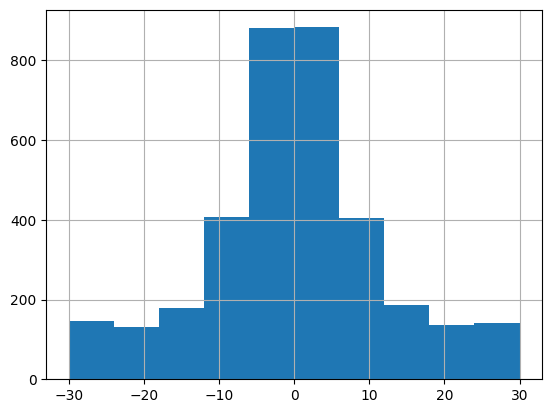

In [24]:
oof_preds[0].hist()

In [25]:
### simple spline, seed(1, 16)~(4, 13)は強制的にfiltaring,  
### seed値に対応して予測スコアも同じ大小関係なら1or0に変換の3モデル
def cal_logloss(pred_vals, y, i):
    y_binary = np.where(y > 0, 1, 0)
    loss = log_loss(y_binary, pred_vals)
    print(f"logloss of cvsplit {i}: {loss:.4f}")


    results.append(f"Normal Spline - logloss of cvsplit {i}: {loss:.4f}")
    return loss

#simple spline
def make_normal_spline(df, y, repeat_cv):
    spline_model1 = []
    logloss_normal = []
    
    for i in range(repeat_cv):
        dat = list(zip(df[i], np.where(y>0, 1, 0)))
        dat = sorted(dat, key=lambda x:x[0])
        datdict = {}
        for k in range(len(dat)):
            datdict[dat[k][0]] = dat[k][1]
        
        spline_model1.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        spline_fit = spline_model1[i](df[i])
        
        loss = cal_logloss(spline_fit, y, i)    
        logloss_normal.append(loss)

    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y>0,1,0),
        "spline": spline_model1[0](df[0])
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()
    
    plt.figure(figsize=(8, 5))
    plt.plot(plot_df.pred_int, plot_df.label, marker='o', linestyle='-', label="True Label")
    plt.plot(plot_df.pred_int, plot_df.spline, marker='x', linestyle='--', label="Spline Approximation")
    plt.xlabel("Predicted Value (Integer)")
    plt.ylabel("Mean Value")
    plt.title("Normal Spline Fit Comparison")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_PATH, f"normal_spline_fit_{PREDICT_YEAR}.png"))
    plt.close()
    
    
    # 例として平均loglossもresultsに記録
    avg_logloss = np.mean(logloss_normal) 
    results.append(f"Average Normal Spline logloss: {avg_logloss:.4f}" if avg_logloss is not None else "No logloss computed")
    
    return spline_model1
            
            
#seed(1, 16)~(4, 13)は強制的にseed通りの結果にフィルタリング
def make_seed1to4_chenge(df, y, repeat_cv):
    spline_model2 = []
    spline_fits = []
    for i in range(repeat_cv):
        dat = list(zip(df[i], np.where(y>0, 1, 0)))
        dat = sorted(dat, key=lambda x:x[0])
        datdict = {}
        for k in range(len(dat)):
            datdict[dat[k][0]] = dat[k][1]
        
        spline_model2.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        spline_fit = spline_model2[i](df[i]) 
        
        #add
        spline_fit[(X.T1_seed==1) & (X.T2_seed==16)] = 1.0
        spline_fit[(X.T1_seed==2) & (X.T2_seed==15)] = 0.9
        spline_fit[(X.T1_seed==3) & (X.T2_seed==14)] = 0.8
        spline_fit[(X.T1_seed==4) & (X.T2_seed==13)] = 0.7
        spline_fit[(X.T1_seed==16) & (X.T2_seed==1)] = 0.0
        spline_fit[(X.T1_seed==15) & (X.T2_seed==2)] = 0.1
        spline_fit[(X.T1_seed==14) & (X.T2_seed==3)] = 0.2
        spline_fit[(X.T1_seed==13) & (X.T2_seed==4)] = 0.3

    
        cal_logloss(spline_fit, y, i)   
                
        spline_fits.append(spline_fit)
        cal_logloss(spline_fit, y, i)   
                
    
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "spline": spline_fits[0]  # 変更後の値を利用
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["spline", "label"]].mean().reset_index()

    plt.figure()
    plt.plot(plot_df.pred_int, plot_df.label, label="label")
    plt.plot(plot_df.pred_int, plot_df.spline, label="spline")
    plt.legend()
    plt.show()
    
    return spline_model2
    
    
#完全に値変換するのではなくてseed値に対応して予測スコアも同じ大小関係なら1or0に変換
def make_seed1to4_base_on_score(df, y, repeat_cv):
    spline_model3 = []
    spline_fits = []

    for i in range(repeat_cv):
        dat = list(zip(df[i], np.where(y>0, 1, 0)))
        dat = sorted(dat, key=lambda x:x[0])
        datdict = {}
        for k in range(len(dat)):
            datdict[dat[k][0]] = dat[k][1]
        
        spline_model3.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        spline_fit = spline_model3[i](df[i]) 
        
        #add
        spline_fit[(X.T1_seed==1) & (X.T2_seed==16) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==2) & (X.T2_seed==15) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==3) & (X.T2_seed==14) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==4) & (X.T2_seed==13) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==16) & (X.T2_seed==1) & (X.T1_Score < X.T2_Score)] = 0.0
        spline_fit[(X.T1_seed==15) & (X.T2_seed==2) & (X.T1_Score < X.T2_Score)] = 0.0
        spline_fit[(X.T1_seed==14) & (X.T2_seed==3) & (X.T1_Score < X.T2_Score)] = 0.0
        spline_fit[(X.T1_seed==13) & (X.T2_seed==4) & (X.T1_Score < X.T2_Score)] = 0.0

        spline_fits.append(spline_fit)
        cal_logloss(spline_fit, y, i)   
    
    
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "spline": spline_fits[0]  # 変更後の値を利用
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["spline", "label"]].mean().reset_index()

    plt.figure()
    plt.plot(plot_df.pred_int, plot_df.label, label="label")
    plt.plot(plot_df.pred_int, plot_df.spline, label="spline")
    plt.legend()
    plt.show()
    return spline_model3



# Platt Scalingを用いた補正曲線生成の関数 (ロジスティック回帰)
def make_platt_scaling(df, y, repeat_cv):
    platt_models = []
    logloss_platt = []
    
    for i in range(repeat_cv):
        X_train = np.array(df[i]).reshape(-1, 1)
        y_binary = np.where(y > 0, 1, 0)
        
        model = LogisticRegression(random_state=42, solver='lbfgs')
        model.fit(X_train, y_binary)
        platt_models.append(model)
        

        platt_fit = model.predict_proba(X_train)[:, 1]
        loss = cal_logloss(platt_fit, y, i)
        logloss_platt.append(loss)
    
    
    ###
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "platt": platt_models[0].predict_proba(np.array(df[0]).reshape(-1, 1))[:, 1]
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["platt", "label"]].mean().reset_index()
    
    plt.figure(figsize=(8, 5))
    plt.plot(plot_df.pred_int, plot_df.label, marker='o', linestyle='-', label="True Label")
    plt.plot(plot_df.pred_int, plot_df.platt, marker='x', linestyle='--', label="Platt Scaling")
    plt.xlabel("Predicted Value (Integer)")
    plt.ylabel("Mean Value")
    plt.title("Platt Scaling Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_PATH, f"platt_scaling_fit_{PREDICT_YEAR}.png"))
    plt.close()
    
    avg_logloss = np.mean(logloss_platt)
    results.append(f"Average Platt Scaling logloss: {avg_logloss:.4f}" if avg_logloss is not None else "No logloss computed")
    
    return platt_models

def make_isotonic_regression(df, y, repeat_cv):
    """ Isotonic Regression を用いた補正曲線生成 """
    isotonic_models = []
    logloss_isotonic = []
    
    for i in range(repeat_cv):
        X_train = np.array(df[i]).reshape(-1, 1)
        y_binary = np.where(y > 0, 1, 0)
        
        model = IsotonicRegression(out_of_bounds="clip")
        model.fit(X_train.ravel(), y_binary)
        isotonic_models.append(model)
        
        isotonic_fit = model.predict(X_train.ravel())
        loss = cal_logloss(isotonic_fit, y, i)
        logloss_isotonic.append(loss)
    
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "isotonic": isotonic_models[0].predict(np.array(df[0]).reshape(-1, 1))
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["isotonic", "label"]].mean().reset_index()
    
    plt.figure(figsize=(8, 5))
    plt.plot(plot_df.pred_int, plot_df.label, marker='o', linestyle='-', label="True Label")
    plt.plot(plot_df.pred_int, plot_df.isotonic, marker='x', linestyle='--', label="Isotonic Regression")
    plt.xlabel("Predicted Value (Integer)")
    plt.ylabel("Mean Value")
    plt.title("Isotonic Regression Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_PATH, f"isotonic_regression_fit_{PREDICT_YEAR}.png"))
    plt.close()
    
    avg_logloss = np.mean(logloss_isotonic)
    results.append(f"Average Isotonic Regression logloss: {avg_logloss:.4f}" if avg_logloss is not None else "No logloss computed")
    
    return isotonic_models



In [26]:
# キャリブレーションカーブの描画関数
def plot_calibration_curve(y_true, y_pred_proba, method, save_path):
    """ キャリブレーションカーブをプロットし保存 """
    y_binary = np.where(y_true > 0, 1, 0) 
    prob_true, prob_pred = calibration_curve(y_binary, y_pred_proba, n_bins=10)
    
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker="o", label=f"{method} Calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Probability")
    plt.legend()
    plt.title(f"{method} Calibration Curve")
    plt.grid()
    plt.savefig(save_path)
    plt.close()



In [27]:
# キャリブレーション手法の選択
spline = MODEL.spline
if spline == "spline_normal":
    spline_model = make_normal_spline(oof_preds, y, repeat_cv)
    calibrated_preds = spline_model[0](oof_preds[0])
    plot_calibration_curve(y, calibrated_preds, "Spline Normal", os.path.join(OUTPUT_PATH, f"spline_normal_calibration_{PREDICT_YEAR}.png"))
    
elif spline == "logistic":
    spline_model = make_platt_scaling(oof_preds, y, repeat_cv)
    calibrated_preds = spline_model[0].predict_proba(np.array(oof_preds[0]).reshape(-1, 1))[:, 1]
    plot_calibration_curve(y, calibrated_preds, "Platt Scaling", os.path.join(OUTPUT_PATH, f"platt_scaling_calibration_{PREDICT_YEAR}.png"))
    
elif spline == "isotonic":
    spline_model = make_isotonic_regression(oof_preds, y, repeat_cv)
    calibrated_preds = spline_model[0].predict(np.array(oof_preds[0]).reshape(-1, 1))
    plot_calibration_curve(y, calibrated_preds, "Isotonic Regression", os.path.join(OUTPUT_PATH, f"isotonic_regression_calibration_{PREDICT_YEAR}.png"))

logloss of cvsplit 0: 0.5073
logloss of cvsplit 1: 0.5078
logloss of cvsplit 2: 0.5075
logloss of cvsplit 3: 0.5064
logloss of cvsplit 4: 0.5074
logloss of cvsplit 5: 0.5068
logloss of cvsplit 6: 0.5052
logloss of cvsplit 7: 0.5062
logloss of cvsplit 8: 0.5065
logloss of cvsplit 9: 0.5067


# submmit

同じfeature engineeringする.

個々の扱うも考える。2025は最終提出用の関数を用意する、その他2024以前は過去コンペでの提出形式に合わせる、でも年度によって提出形式が変わるからとりあえず2023でやる

In [28]:
"""if PREDICT_YEAR==2022:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2022M.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)
elif PREDICT_YEAR==2023:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2023.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)
elif PREDICT_YEAR==2024:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2024.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)
elif PREDICT_YEAR==2025:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmissionStage2.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))   
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)"""
    

'if PREDICT_YEAR==2022:\n    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2022M.csv"))\n    sub[\'Season\'] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[0]))\n    sub["T1_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[1]))\n    sub["T2_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[2]))\n    sub_X, a = process_tourney(sub, mode = "sub")\n    dtest = xgb.DMatrix(sub_X)\nelif PREDICT_YEAR==2023:\n    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2023.csv"))\n    sub[\'Season\'] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[0]))\n    sub["T1_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[1]))\n    sub["T2_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[2]))\n    sub_X, a = process_tourney(sub, mode = "sub")\n    dtest = xgb.DMatrix(sub_X)\nelif PREDICT_YEAR==2024:\n    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2024.csv"))\n    sub[\'Season\'] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[0]

In [29]:
sub = notexist.copy()
sub = sub.rename(columns={"WTeamID": "T1_TeamID", "LTeamID": "T2_TeamID"})
sub = sub[["Season", "T1_TeamID", "T2_TeamID"]]
temp = sub.copy()
temp = temp.rename(columns={"T1_TeamID": "T2_TeamID", "T2_TeamID": "T1_TeamID"})
sub = pd.concat([sub, temp]).reset_index()
sub_X, a = process_tourney(sub, mode="sub")
dtest = xgb.DMatrix(sub_X)

no fillna, use nan


In [30]:
sub_models = []
#sokutionではカスタム関数の指定、早期停止の言及がここではなかった。検討する
for i in tqdm(range(repeat_cv), leave=True, dynamic_ncols=True):
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          obj=cauchyobj,
          num_boost_round = int(iteration_counts[i] * 1.05),
          #early_stopping_rounds=early_stopping_rounds, #これ指定してない、指定するのかあと、指定するとしても少し遅くさせるとか
          verbose_eval = 50
        )
    )

  0%|                                                                                                                                                            | 0/10 [00:00<?, ?it/s]

 10%|██████████████▊                                                                                                                                     | 1/10 [00:03<00:28,  3.14s/it]

 20%|█████████████████████████████▌                                                                                                                      | 2/10 [00:06<00:25,  3.15s/it]

 30%|████████████████████████████████████████████▍                                                                                                       | 3/10 [00:09<00:21,  3.13s/it]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 4/10 [00:12<00:18,  3.02s/it]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 5/10 [00:15<00:15,  3.08s/it]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6/10 [00:18<00:12,  3.02s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7/10 [00:21<00:09,  3.05s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8/10 [00:24<00:06,  3.13s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9/10 [00:27<00:03,  3.08s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.00s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.06s/it]

各特徴量の寄与度を算出

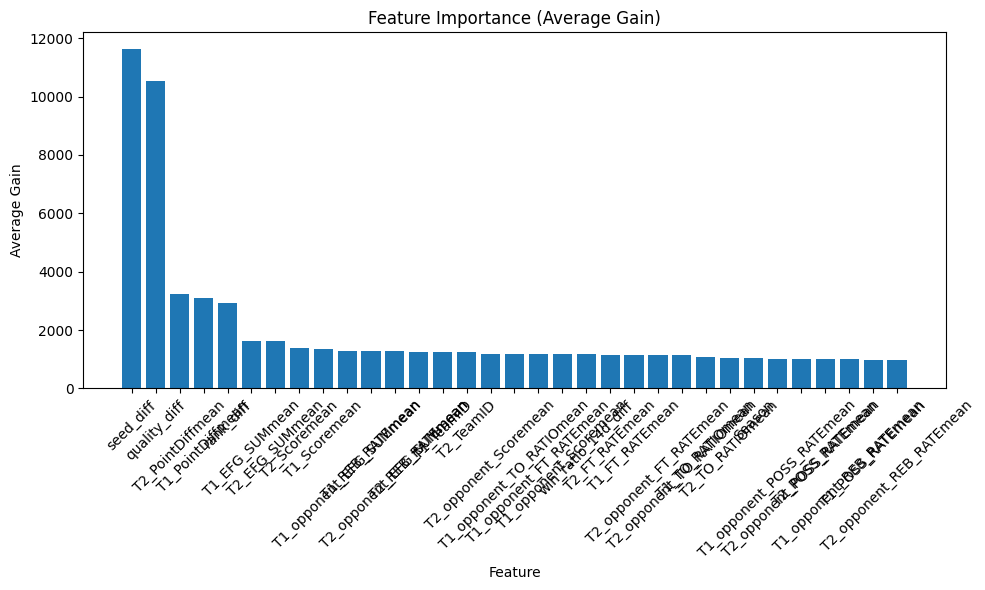

In [31]:
feature_importances = collections.defaultdict(list)
for model in sub_models:
    importance = model.get_score(importance_type='gain')
    for feat, score in importance.items():
        feature_importances[feat].append(score)

avg_importance = {feat: sum(scores) / len(scores) for feat, scores in feature_importances.items()}
fi_df = pd.DataFrame(list(avg_importance.items()), columns=['Feature', 'Avg_Gain'])
fi_df.sort_values(by='Avg_Gain', ascending=False, inplace=True)
results.append("")
fi_log = "-----Feature Importance (Average Gain)-----\n"
for feat, score in fi_df.values:
    fi_log += f"{feat}: {score:.4f}\n"
results.append(fi_log)
results.append("")

plt.figure(figsize=(10, 6))
plt.bar(fi_df['Feature'], fi_df['Avg_Gain'])
plt.xlabel('Feature')
plt.ylabel('Average Gain')
plt.title('Feature Importance (Average Gain)')
plt.xticks(rotation=45)
plt.tight_layout() 

plt.savefig(os.path.join(OUTPUT_PATH, f"feature_importance_{PREDICT_YEAR}.png"))
plt.show()

In [32]:
sub_preds = []
for i in tqdm(range(repeat_cv)):
    if spline == "spline_normal":
        sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest), -30, 30)), 0.025, 0.975))
    
    elif spline == "logistic":
        X_input = np.clip(sub_models[i].predict(dtest), -30, 30).reshape(-1, 1)
        platt_pred = spline_model[i].predict_proba(X_input)[:, 1]
        sub_preds.append(np.clip(platt_pred, 0.025, 0.975))

    elif spline == "isotonic":
        X_input = np.clip(sub_models[i].predict(dtest), -30, 30).reshape(-1, 1)
        iso_pred = spline_model[i].predict(X_input)  # Isotonic Regression の適用
        sub_preds.append(np.clip(iso_pred, 0.025, 0.975))

sub["Pred"] = np.mean(np.vstack(sub_preds), axis=0)

  0%|                                                                                                                                                            | 0/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 201.79it/s]

In [33]:
# teams:64team, targetを受け取って、そのtarget teamの試合可能性のある全63試合を抽出する関数
def extract_target_team_records(submission_df, teams, target_team):
    if target_team not in teams:
        raise ValueError(f"target_team {target_team} は teams 内に存在しません")

    remaining_teams = [t for t in teams if t != target_team]
    
    records = []
    for other_team in remaining_teams:
        lower = min(target_team, other_team)
        higher = max(target_team, other_team)
        row = submission_df[(submission_df['T1_TeamID'] == lower) & (submission_df['T2_TeamID'] == higher)]
        if row.empty:
            print(f"Warning: 対戦 {lower} vs {higher} に対応するレコードが見つかりませんでした")
        else:
            records.append(row)
    
    if records:
        final_records = pd.concat(records, ignore_index=True)
    else:
        final_records = pd.DataFrame()
    
    if len(final_records) != 63:
        print(f"Warning: 期待される63件ではなく、{len(final_records)}件のレコードが抽出されました。")
    
    return final_records


In [34]:
tourney_teams_2023 = [
    1395, 1113,   # TCU1395, アリゾナ・ステイト1113
    1231, 1245,   # インディアナ1231, ケント・ステイト1245
    1243, 1286,   # カンザス・ステイト1243, モンタナ・ステイト1286
    1272, 1194,   # メンフィス1272, ﾌﾛﾘﾀﾞ･ｱﾄﾗﾝﾃｨｯｸ1194
    1211, 1213,   # ゴンザガ1211, グランド・キャニオン1213
    1274, 1179,   # マイアミ（フロリダ）1274, ドレイク1179
    1243, 1286,   # ケンタッキー1243, プロビデンス1286
    1345, 1192,   # パデュー1345, ﾌｪｱﾘｰ･ﾃﾞｨｷﾝｿﾝ1192
    1163, 1233,   # コネチカット1163, アイオナ1233
    1166, 1301,   # クレイトン1166, ﾉｰｽｶﾛﾗｲﾅ･ｽﾃｲﾄ1301
    1235, 1338,   # アイオワ・ステイト1235, ピッツバーグ1338
    1266, 1436,   # マーケット1266, バーモント1436
    1388, 1433,   # ｾﾝﾄﾒｱﾘｰｽﾞ（ｶﾘﾌｫﾙﾆｱ）1388, VCU1433
    1124, 1364,   # ベイラー1124, UCサンタバーバラ1364
    1462, 1244,   # ザビエル1462, ケネソー・ステイト1244
    1277, 1425,   # ミシガン・ステイト1277, USC トロージャンズ1425

    1417, 1421,   # UCLA1417, UNC アシュビル1421
    1401, 1336,   # テキサス A＆M1401, ﾍﾟﾝｼﾞﾙﾍﾞﾆｱ･ｽﾃｲﾄ1336
    1397, 1418,   # テネシー1397, ﾙｲｼﾞｱﾅ･ﾗﾌｧｲｴｯﾄ1418
    1222, 1297,   # ヒューストン1222, ノーザンケンタッキー1297
    1321, 1129,   # ノースウェスタン1321, ボイシ・ステイト1129
    1400, 1159,   # テキサス1400, コルゲート1159
    1181, 1331,   # デューク1181, オーラル・ロバーツ1331
    1234, 1120,   # アイオワ1234, オーバーン1120
    1116, 1228,   # アーカンソー1116, イリノイ1228
    1112, 1343,   # アリゾナ1112, プリンストン1343
    1361, 1158,   # ｻﾝﾃﾞｴｺﾞ･ｽﾃｲﾄ1361, チャールストン1158
    1104, 1394,   # アラバマ1104, テキサス A＆M CC1394
    1242, 1224,   # カンザス1242, ハワード1224
    1281, 1429,   # ミズーリ1281, ユタ・ステイト1429
    1438, 1202,   # バージニア1438, ファーマン1202
    1268, 1452    # メリーランド1268, ウェストバージニア1452
]

#Connecticut_vs = extract_target_team_records(sub, tourney_teams_2023, 1163 )

In [35]:
#handlabelingを行う関数
def make_handlabeling(df, season, T1, T2, labeling_pred, tourney_teams):
    if T1 not in tourney_teams or T2 not in tourney_teams: 
        print(f"トーナメント対象チームに属していません")
        return 
    
    if T1>T2: 
        T1, T2 = T2, T1
        print(f"{T1}, {T2}ID逆だけど大丈夫？？")
    id = f"{season}_{T1}_{T2}"

    print(f"before: {df[df['ID']==id]}")
    df.loc[df["ID"] == id, "Pred"] = labeling_pred
    print(f"after: {df[df['ID']==id]}")
    
    results.append(f"-----handolabeling-----")
    results.append(f"before:  {df[df['ID']==id]} -----> after: {df[df['ID']==id]}")
    results.appedn("")
    return df

In [36]:
labeling = cfg.exp.hand_labeling
if labeling is not None:
    for i in range(len(labeling)):
        T1 = labeling[i][0]
        T2 = labeling[i][1]
        labeling_pred = labeling[i][2]
        
        print(f"{T1} vs {T2} result labeling {labeling_pred}")
        
        sub = make_handlabeling(sub, PREDICT_YEAR, T1, T2, labeling_pred, tourney_teams_2023)

Tournament matchups only - Pred Mean: 0.4994008340225424


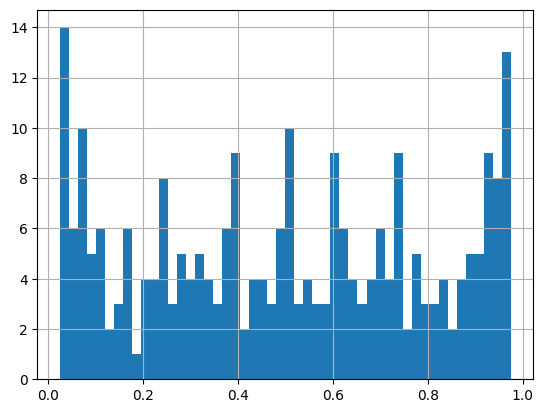

In [37]:
tourney_filtered = notexist[notexist["Season"] == PREDICT_YEAR].copy()
a = tourney_filtered.rename(columns={'WTeamID': 'T1_TeamID', 'LTeamID': 'T2_TeamID'})
b = tourney_filtered.rename(columns={'WTeamID': 'T2_TeamID', 'LTeamID': 'T1_TeamID'})
ab = pd.concat([a, b]).reset_index(drop=True) 
filtered_sub = sub.merge(ab[['Season', 'T1_TeamID', 'T2_TeamID']], 
                         on=['Season', 'T1_TeamID', 'T2_TeamID'], 
                         how='inner')

filtered_sub["Pred"].astype(int)
pred_mean = filtered_sub["Pred"].mean()
print("Tournament matchups only - Pred Mean:", pred_mean)

filtered_sub["Pred"].hist(bins=50)
results+=["", f"Tournament matchups only - Pred Mean:, {pred_mean}", ""]
plt.figure(figsize=(8, 6))
filtered_sub["Pred"].hist(bins=50)
plt.title("Prediction Histogram")
plt.xlabel("Pred")
plt.ylabel("Frequency")
plt.grid(True)

# 画像として保存
plt.savefig(os.path.join(OUTPUT_PATH, f"Prediction_Histgram_filtered_{PREDICT_YEAR}.png"))
plt.close()

# スコア算出、まとめ、
ここまでで提出ファイル作成。ここからは過去年度のシミュレーションに対してBrier scoreやその他指標の算出

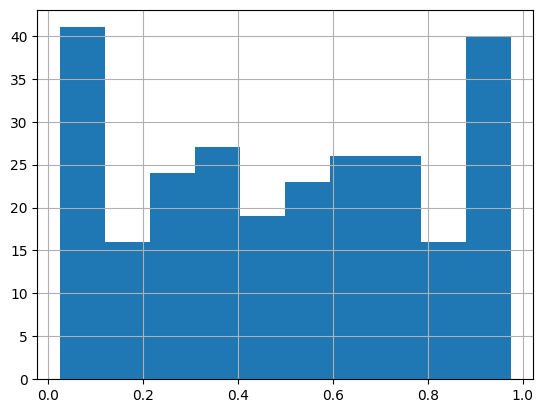

In [38]:
sub["Pred"].hist()
results+=["", f"Pred mean: {sub['Pred'].mean()}", ""]

plt.figure(figsize=(8, 6))
sub["Pred"].hist(bins=50)
plt.title("Prediction Histogram")
plt.xlabel("Pred")
plt.ylabel("Frequency")
plt.grid(True)

# 画像として保存
plt.savefig(os.path.join(OUTPUT_PATH, f"Prediction_Histgram_{PREDICT_YEAR}.png"))
plt.close()

存在するはずのない予測年度のトーナメント結果をもとに(Pred, label)を取り出し、以下を行う。

- 各評価指標の計算
- キャリブレーション可視化
- AUC可視化

In [39]:
def extract_labels_and_preds(sub, tourney):
    """ 試合データから予測値 (Pred) と正解ラベル (label) を抽出する """
    label_data = tourney[["WTeamID", "LTeamID", "WScore", "LScore"]]
    label_data = label_data.rename(columns={"WTeamID": "T1_TeamID", "LTeamID": "T2_TeamID", "WScore": "T1_Score", "LScore": "T2_Score"})
    temp = label_data.copy()
    temp = temp.rename(columns={"T1_TeamID": "T2_TeamID", "T2_TeamID": "T1_TeamID", "T1_Score": "T2_Score", "T2_Score": "T1_Score"})
    label_data = pd.concat([label_data, temp]).reset_index(drop=True)
    
    label_data = pd.merge(label_data, sub, on=["T1_TeamID", "T2_TeamID"], how="left")
    label_data["label"] = np.where(label_data["T1_Score"] - label_data["T2_Score"] > 0, 1, 0)
    label_data = label_data.dropna(subset=["Pred"])  # 欠損値を削除
    
    return label_data[["label", "Pred"]]

def calculate_metrics(label_data):
    """ 各評価指標を計算 """
    brier_score = round(mean_squared_error(label_data["label"], label_data["Pred"]), 4)  # Brier Score (MSEと同じ)
    rmse_score = round(mean_squared_error(label_data["label"], label_data["Pred"], squared=False), 4)  # RMSE
    logloss_score = round(log_loss(label_data["label"], label_data["Pred"]), 4)  # Log Loss
    mae_score = round(mean_absolute_error(label_data["label"], label_data["Pred"]), 4)  # MAE
    
    return {
        "Brier Score": brier_score,
        "RMSE": rmse_score,
        "Log Loss": logloss_score,
        "MAE": mae_score
    }

def plot_calibration_curve(label_data, n_bins=10):
    """ キャリブレーションカーブをプロット """
    prob_true, prob_pred = calibration_curve(label_data["label"], label_data["Pred"], n_bins=n_bins)
    
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker="o", label="Model Calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Probability")
    plt.legend()
    plt.title("Calibration Curve")
    plt.show()

def calculate_auc_metrics(label_data):
    global results
    """ AUC-ROCとAUC-PRを計算 """
    auc_roc = roc_auc_score(label_data["label"], label_data["Pred"])
    auc_pr = average_precision_score(label_data["label"], label_data["Pred"])
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    results += ["---- AUC -----", f"AUC-ROC: {auc_roc:.4f}", f"AUC-PR: {auc_pr:.4f}"]
    

C:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


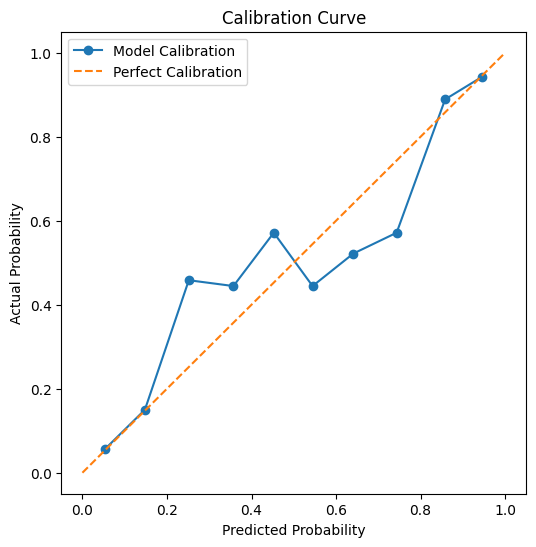

AUC-ROC: 0.7916
AUC-PR: 0.8025
MAE: 0.3483

---- AUC -----
AUC-ROC: 0.7916
AUC-PR: 0.8025


In [40]:
if PREDICT_YEAR == 2022:
    notexist_MAN = notexist[notexist["WTeamID"].astype(str).str.startswith("1")]
    notexist_WOMAN = notexist[notexist["WTeamID"].astype(str).str.startswith("3")]
    label_data = extract_labels_and_preds(sub, notexist) ######
else:
    label_data = extract_labels_and_preds(sub, notexist)

# 評価指標の計算
score = calculate_metrics(label_data)
results += ["","-----eval metrics-----",
            f"Brier Score: {score['Brier Score']}", 
            f"RMSE: {score['RMSE']}", 
            f"Log Loss: {score['Log Loss']}", 
            f"MAE: {score['MAE']}", ""]

# キャリブレーションの確認
plot_calibration_curve(label_data)

# AUCの評価
calculate_auc_metrics(label_data)

for temp in range(-5, 0):
    print(results[temp])

In [41]:
"""if PREDICT_YEAR!=2025:
    predict_year_label =notexist[["WTeamID", "LTeamID", "WScore", "LScore"]].copy()
    predict_year_label.loc[:, "Win"] = np.where(predict_year_label["WScore"] - predict_year_label["LScore"] > 0, 1, 0)
    predict_year_label = predict_year_label[["WTeamID", "LTeamID", "Win"]]
   
    predict_year_label.columns = ["T1_TeamID", "T2_TeamID", "Win"]

    predict_year_label = pd.merge(predict_year_label, sub, on=["T1_TeamID", "T2_TeamID"], how="left")
    brier_score = np.mean((predict_year_label["Pred"] - predict_year_label["Win"])**2)

    print("Brier Score:", brier_score)
    results+=[f"Brier Score: {brier_score}", ""]
    predict_year_label.info()
"""

'if PREDICT_YEAR!=2025:\n    predict_year_label =notexist[["WTeamID", "LTeamID", "WScore", "LScore"]].copy()\n    predict_year_label.loc[:, "Win"] = np.where(predict_year_label["WScore"] - predict_year_label["LScore"] > 0, 1, 0)\n    predict_year_label = predict_year_label[["WTeamID", "LTeamID", "Win"]]\n   \n    predict_year_label.columns = ["T1_TeamID", "T2_TeamID", "Win"]\n\n    predict_year_label = pd.merge(predict_year_label, sub, on=["T1_TeamID", "T2_TeamID"], how="left")\n    brier_score = np.mean((predict_year_label["Pred"] - predict_year_label["Win"])**2)\n\n    print("Brier Score:", brier_score)\n    results+=[f"Brier Score: {brier_score}", ""]\n    predict_year_label.info()\n'

In [42]:
END_TIME = time.time()
ELAPSED_TIME = END_TIME - START_TIME
print(f"実行時間： {ELAPSED_TIME:.1f}秒")
results.append(f"実行時間： {ELAPSED_TIME:.1f}秒")

with open(os.path.join(OUTPUT_PATH, "result.txt"), "a", encoding="utf-8") as f:
    for line in results:
        f.write(line + "\n")

実行時間： 333.7秒


In [43]:
logger.remove()